# Introduction

In this notebook we are going to develop a simple dual-loop feedback control system to balance and direct a bicycle. Bicycles have several interesting properties from a dynamics and control perspective and I will highlight those features throughout the notebook. In general, a bicycle requires control to both balance and direct the vehicle and the steering is the primary input with the most control authority.

To balance a bicycle one must steer into the fall. This means that if the bicycle is falling (rolling) to the left, the steering must ultimately be directed towards the left to keep the bicycle upright. To direct the bicycle we use this fact and effectively execute "controlled falls" to change the direction of travel.

# Open Loop Bicycle Model

To come up with a suitable controller we first need a model that describes the open loop dynamics of the system, i.e. a plant model. The model I will use is pretty much the simplest model of a bicycle that will allow one to study the steer into the fall mechanism. The assumptions that the model is founded on are as follows:

- The bicycle and rider mass and inertia are all lumped into a single rigid body.
- The front assembly (handlebars, fork, and wheel) are massless and thus no effort is required to change the direction of the steering angle.
- There is no gyroscopic effects from the spinning wheels (they are treated more like skates or skis).

The following diagram describes the essential components and variables in the model:

![](model-diagram.svg)

With these variable definitions:

- $m$: Combined mass of the bicycle and the rider
- $h$: Heght of the center of mass
- $a$: Distance from rear wheel coddnter of mass
- $b$: Wheelbase
- $v_r$: Speed at rear wheel
- $g$: Acceleration due to gravity
- $I_1,I_2,I_3$: Principal moments of inertia of the combined bicycle and rider
- $\delta(t)$: Steering angle
- $\theta(t)$: Roll angle
- $\dot{\psi}(t)$: Heading angular rate

The non-linear equation of motion of this model can be written as so:

$$
(I_x + mh^2) \ddot{\theta} +
(I_3 - I_2 - mh^2)\left(\frac{v_r \tan\delta}{b}\right)^2 \sin\theta\cos\theta
-mgh\sin\theta
=-mh\cos\theta \left(\frac{av_r}{b\cos^2\delta}\dot{\delta}+\frac{v_r^2}{b}\tan{\delta}\right)
$$

The left hand side describes the natural roll dynamics and the right hand side gives the roll torque produced by steering.

Additionally, the heading can described by this differential equation:

$$ \dot{\psi} = \frac{v_r}{b}\tan{\delta} $$

# Linearize the Model

The non-linear model presented above can be linearized about the upright equilibrium configuration ($\theta=\delta=0$). The simplest method to put these equations into a linear form is to assume that all of the angles are small. This means that $\sin\theta=\theta$, $\cos\theta=1$, $\cos\delta=1$, $\tan\delta=\delta$, and $\tan^2(\delta)=0$. With that assumption and defining $I=I_1$ and $v=v_r$the linear equation of motion can now be written as:

$$ (I + mh^2) \ddot{\theta} - mgh\theta = -\frac{mh}{b}\left(av\dot{\delta}+v^2\delta\right) $$

With $\theta$ as the output variable and $\delta$ as the input variable a transfer function can be created by transforming the above equation into the frequency domain.

$$ \frac{\theta(s)}{\delta(s)} = 
-\frac{mhv}{b} \frac{as + v}{(I + mh^2)s^2 - mgh}$$

The same can be done for the heading differential equation:

$$\dot{\psi}=\frac{v}{b}\delta$$

$$\frac{\psi(s)}{\delta(s)}= \frac{v}{bs}$$

# Dependency Installation

Before we begin designing the controller we will need to install some dependencies. The simplest way to get everything is to use conda and setup an environment with just the necessary packages:

```
$ conda create -n bicycle-control pip numpy scipy ipython-notebook
$ source activate bicycle-control
(bicycle-control)$ conda install -c https://conda.binstar.org/cwrowley slycot control
(bicycle-control)$ pip install plotly # Plotly needs a conda package!
```

In [1]:
import numpy as np
import control as cn
import plotly.plotly as pl
import plotly.graph_objs as gr

# Controller Design

At this point we can us the linear model as a foundation for a controller design. First, some reasonble numerical values for each of the model constants are specified.

In [2]:
g = 9.81  # m/s^2
m = 87.0  # kg
I = 3.28  # kg m^2
h = 1.0  # m
a = 0.5  # m
b = 1.0  # m
v = 5.0  # m/s

The Python Control package has a transfer function object that I will use to specify all of the transfer functions we will need in the control design. The first transfer function to specify is the plant, $\frac{\theta(s)}{\delta(s)}$. This transfer function provides a second order linear relationship relating the roll angle of the bicycle, $\theta$, to the steering angle, $\delta$.

In [3]:
num = -m * h * v / b * np.array([a, v])
den = np.array([(I + m * h**2), 0.0, -m * g * h])
theta_delta = cn.TransferFunction(num, den)
theta_delta


 -217.5 s - 2175
-----------------
90.28 s^2 - 853.5

The first thing we may ask is whether or not the system is stable? It is fairly obvious from the denominator of the transfer function (i.e. the characteristic equation), but we can use the `.pole()` method of a transfer function to compute the roots of the characteristic equation. If any of the poles have positive real parts, then we know the system is unstable.

In [4]:
theta_delta.pole()

array([-3.0746689,  3.0746689])

Now we see clearly that we have a pair of real poles, where one is positive, indicating that our system is unstable. This is identical to the behavior of a simple inverted pendulum.

The next thing that may be of interest is the step response of the system. We know that the system is unstable but the step response can possibly reveal other information. I will use the `forced_response` function so that we can control the magnitude of the step input.

In [5]:
time = np.linspace(0.0, 5.0, num=1001)

In [6]:
delta = np.deg2rad(2.0) * np.ones_like(time)

In [7]:
time, theta, state = cn.forced_response(theta_delta, T=time, U=delta)

Now I'll create a reusable function for plotting a SISO input/output time history.

In [8]:
def plot_siso_response(time, input, output, title='Time Response',
                       x_lab='Time [s]', x_lim=None,
                       input_y_lab='Input', input_y_lim=None,
                       output_y_lab='Output', output_y_lim=None):
    """Plots a time history of the input and output of a SISO system."""
    
    input_trace = gr.Scatter(x=time, y=input)
    output_trace = gr.Scatter(x=time, y=output, yaxis='y2')
    
    xaxis = gr.XAxis(title=x_lab, range=x_lim)
    yaxis = gr.YAxis(title=input_y_lab, range=input_y_lim, domain=[0.0, 0.49])
    yaxis2 = gr.YAxis(title=output_y_lab, range=output_y_lim, domain=[0.51, 1.0])
   
    layout = gr.Layout(title=title, xaxis=xaxis,
                       yaxis=yaxis, yaxis2=yaxis2)
    
    data = gr.Data([input_trace, output_trace])
    
    fig = gr.Figure(data=data, layout=layout)
    
    return fig

Now we can plot the first simulatio of the system's response to a positive step input of 2 degrees. This plot shows that if you apply a positive steer angle the roll angle expontentially grows in the negative direction. So forcing the steering to the right will make you fall to the left. This opposite what one finds in most vehicles. Typically steering to the right causes you to go to the right. This will influence our controller design.

In [9]:
pl.iplot(plot_siso_response(time, np.rad2deg(delta),np.rad2deg(theta), title='Step Response',
                            output_y_lab='Roll Angle [deg]', input_y_lab='Steer Angle [deg]'))

Now it may be interesting to see if a simple proportional controller can stablize this model and what kind of gain value is needed to do so. One way to do this is to compute the root locus of the closed loop system with a varying gain. A root locus is most informative if plotted so here we define a function that will plot the roots as a function of the gains on the imaginary plane.

In [10]:
def plot_root_locus(gains, roots):
    
    real_vals = np.real(roots)
    imag_vals = np.imag(roots)
    
    #omega_n = np.sqrt(real_vals**2 + imag_vals**2)
    #damping = real_vals / omega_n
    
    xaxis = gr.XAxis(title='Re')
    yaxis = gr.YAxis(title='Im')
    layout = gr.Layout(title='Root Locus', xaxis=xaxis, yaxis=yaxis)
    
    # plots an x for the first roots
    open_loop_poles = gr.Scatter(x=real_vals[0, :],
                                 y=imag_vals[0, :],
                                 marker=gr.Marker(symbol='x', color='blue'),
                                 mode='markers')
    
    # plots an x for the first roots
    last_poles = gr.Scatter(x=real_vals[-1, :],
                            y=imag_vals[-1, :],
                            marker=gr.Marker(symbol='o', color='blue'),
                            mode='markers')
    data = []
    
    # TODO : Would be cool to add the damping ratio and frequency of the root.
    gain_text = ['k = {:1.2f}'.format(k) for k in gains]
    
    for r, i in zip(real_vals.T, imag_vals.T):
        data.append(gr.Scatter(x=r, y=i, text=gain_text,
                               marker=gr.Marker(color='black'), mode="markers"))
                
    data.append(open_loop_poles)
    data.append(last_poles)
    
    return gr.Figure(data=gr.Data(data), layout=layout)

The root locus can be computed with Python Control's `root_locus` function. Let's see if various negative feedback gains will stablize the system.

In [11]:
neg_feedback_roots, neg_feedback_gains = cn.root_locus(theta_delta,
    kvect=np.linspace(0.0, 10.0, num=500))

The root locus shows that for increasing negative feedback gains we simply cause the bicycle to fall over even faster. (Use the "Show closest data on hover" option in the Plotly graph and hover over the traces to see the value of the gain.) We already knew that the a right steer makes you fall to the left. So if we are falling to the left we have a positive error causing steering to the right! Which of course makes us fall over even faster. So what if we used positive feedback instead?

In [12]:
pl.iplot(plot_root_locus(neg_feedback_gains, neg_feedback_roots))

Now this is much better. It seems that if we apply positive feedback that the system can indeed be stablized by the controller. So if we command a roll angle we must steer in the same direction to obtain that roll angle. This proves that we must steer into the fall in order to balance a bicycle.

In [13]:
pos_feedback_roots, pos_feedback_gains = cn.root_locus(theta_delta,
    kvect=np.linspace(0.0, -20.0, num=500))
pl.iplot(plot_root_locus(pos_feedback_gains, pos_feedback_roots))

In [14]:
re = np.real(pos_feedback_roots)
w_d = np.imag(pos_feedback_roots)
f_d = w_d / 2.0 / np.pi
w_n = np.sqrt(re**2 + w_d**2)
f_n = w_n / 2.0 / np.pi
zeta = np.abs(re) / w_n

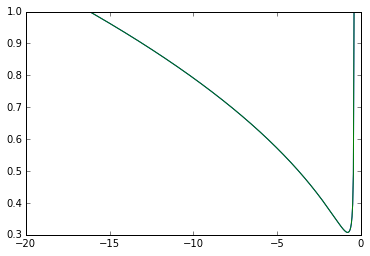

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(pos_feedback_gains, zeta)

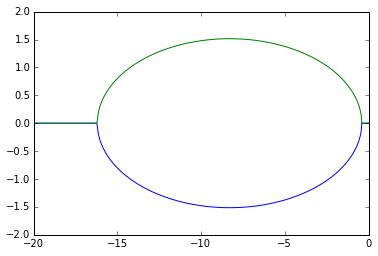

In [16]:
plt.plot(pos_feedback_gains, f_d)

Now that we know we can stablize the system with positive feedback based on the roll angle error, we can choose a suitable controller that will allow us to command a roll angle. The ability to command a roll angle is the first step to commanding a direction, i.e. heading. To head in the right direction the bicycle must eventually be steered and rolled to the right. So if we can command a rightward roll we are one step away from commanding a rightward turn.

Our system is a Type 0 system, thus a simple proportional feedback system will stablize the system but there will be some steady state error. One way to rememdy this is to introduce an additive integral control term to remove the steady state error. For this I'll create a function that generates a PID controller transfer function.

In [17]:
def pid(kp, ki, kd):
    """Returns a PID controller given the three gains."""
    return (cn.TransferFunction(kp, [1.0]) +
            cn.TransferFunction(ki, [1.0, 0.0]) +
            cn.TransferFunction([kd, 0.0], [1.0]))

In [18]:
kp = -7.0
ki = -1.0
kd = -0.0

In [19]:
roll_controller = pid(kp, ki, kd)
roll_controller


-7 s - 1
--------
    s

In [20]:
def feedback(plant, controller):
    feedforward = controller * plant
    return (feedforward / (1 + feedforward)).minreal()

In [21]:
theta_thetac = feedback(theta_delta, roll_controller)
theta_thetac


   16.86 s^2 + 171.1 s + 24.09
---------------------------------
s^3 + 16.86 s^2 + 161.6 s + 24.09

In [22]:
theta_thetac.zero()

array([-10.        ,  -0.14285714])

In [23]:
theta_thetac.pole()

array([-8.35637161+9.44655366j, -8.35637161-9.44655366j, -0.15145704+0.j        ])

In [24]:
np.deg2rad(10.0)

0.17453292519943295

In [25]:
thetac = np.deg2rad(3.0) * np.ones_like(time)
time, theta, state = cn.forced_response(theta_thetac, T=time, U=thetac)

In [26]:
pl.iplot(plot_siso_response(time, np.rad2deg(thetac), np.rad2deg(theta),
                            input_y_lab='Commanded Roll Angle [deg]',
                            output_y_lab='Roll Angle [deg]'))

In [27]:
thetae = thetac - theta

In [28]:
time, steer, state = cn.forced_response(roll_controller, T=time, U=thetae)

In [29]:
pl.iplot(plot_siso_response(time, np.rad2deg(thetae), np.rad2deg(steer),
                           input_y_lab='Roll Error [deg]',
                           output_y_lab='Steer Angle [deg]'))

In [30]:
delta_theta = cn.TransferFunction(theta_delta.den, theta_delta.num)
delta_theta


90.28 s^2 - 853.5
-----------------
 -217.5 s - 2175

In [31]:
psi_delta = cn.TransferFunction([v], [b, 0])
psi_delta


5
-
s

In [32]:
psi_thetac = (theta_thetac * delta_theta * psi_delta).minreal()
psi_thetac


  -35 s^3 - 5 s^2 + 330.9 s + 47.27
-------------------------------------
s^4 + 16.86 s^3 + 161.6 s^2 + 24.09 s

In [33]:
psi_thetac.pole()

array([-8.35637161+9.44655366j, -8.35637161-9.44655366j,
       -0.15145704+0.j        ,  0.00000000+0.j        ])

In [34]:
psi_thetac.zero()

array([ 3.0746689 , -3.0746689 , -0.14285714])

In [35]:
time, psi, state = cn.forced_response(psi_thetac, T=time, U=thetac)

In [36]:
pl.iplot(plot_siso_response(time, np.rad2deg(thetac), np.rad2deg(psi)))

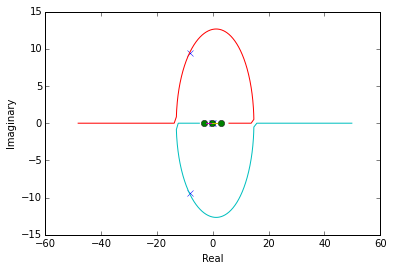

In [37]:
roots, gains = cn.root_locus(psi_thetac, kvect=np.linspace(-1.0, 2.0, num=1001))

In [38]:
pl.iplot(plot_root_locus(gains, roots))

In [46]:
psi_psic = feedback(psi_thetac, pid(0.1, 0.0, 0.0))
psi_psic.minreal()


     -3.5 s^3 - 0.5 s^2 + 33.09 s + 4.727
---------------------------------------------
s^4 + 13.36 s^3 + 161.1 s^2 + 57.18 s + 4.727

In [47]:
psi_psic.pole()

array([-6.50049496+10.68123698j, -6.50049496-10.68123698j,
       -0.23402070 +0.j        , -0.12918965 +0.j        ])

In [48]:
psic = np.deg2rad(10.0) * np.ones_like(time)
time, heading, state = cn.forced_response(psi_psic, T=time, U=psic)

In [49]:
pl.iplot(plot_siso_response(time, np.rad2deg(psic), np.rad2deg(heading)))